*best viewed in [nbviewer](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/results/notebooks/time_distribution_and_pos.ipynb)*

<center><h1>Time Distribution and "Parts of Speech":</h1></center>
<center><h2>Beginning Analysis of Hebrew Time Adverbials</h2></center>
<center><h3 style="font-weight:normal">Cody Kingham</h3></center>
<center><h2><a href="../../docs/sponsors.md"><img height=20% width=20% src="../../docs/images/CambridgeU_BW.png"></a></h2></center>

In [2]:
! echo "last updated:"; date

last updated:
Sun 26 Jan 2020 00:19:02 GMT


## The Phenomena of "Time Adverbials"

Time adverbials are crucial and ubiquitous constructions in the clause structures of worldwide languages ([Klein 1994; Haspelmath 1997](../../docs/bibliography.txt)). These arguments, which can consist of any unit from single words up to dependent clauses, coordinate with the main verb, alongside other arguments, to locate and modify events/predications. Word and phrasal time adverbials derive from two main sources: words prototypically used as "adverbs," and noun phrases. Adverbs are occasionally distinguished by morphological features. In Biblical Hebrew, for instance, the suffix *-am* distinguishes words like יומם as adverbial. But in Hebrew explicit morphological markers are otherwise rare. Adverbs have to be distinguished syntactically and behaviorally instead. Noun-based time adverbials are the genetic descendants of locative phrases (Haspelmath 1997). They are most frequently prepositional, and they utilize other elements common to noun phrases: definite articles, demonstratives, quantifiers, construct states, etc.

In this notebook, we (me and you) will set out the primary surface forms of attested time adverbials in the Hebrew Bible, meaning we will compare and quantify all identical and similar phrases. We will visualize and model the distribution of time adverbials across the whole Hebrew Bible. And finally we will investigate the validity of so-called "parts of speech." By what criteria does one define a "part of speech"? How do these categories affect the interpretation of time adverbials in Biblical Hebrew? And is it possible to derive a data-driven approach to such an analysis?

<hr>

<center><h1>Python</h1></center>

## Import Modules and Data

We need packages and code to import and process the data. Let's get started!

In [14]:
# standard packages
from pathlib import Path
import collections
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.serif'] = ['SBL Biblit']
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
from sklearn.decomposition import PCA
from adjustText import adjust_text
from bidi.algorithm import get_display # bi-directional text support for plotting

# import custom modules (kept under /tools)
# !NB! add to Python path to avoid Module Not Found errors
from stats.significance import contingency_table, apply_fishers
from stats.pca import plot_PCA
from paths import figs, main_table
from helpers import Figures, reverse_hb
from tf_tools.load import load_tf
from cx_analysis.load import cxs
from cx_analysis.search import SearchCX

# set up Text-Fabric methods for navigating corpus data
TF, API, A = load_tf(silent='deep')
A.displaySetup(condenseType='phrase')
F, E, T, L = A.api.F, A.api.E, A.api.T, A.api.L

# import Construction objects for more corpus data + syntax structures
se = SearchCX(A)
phrase2cxs = cxs['phrase2cxs']
class2cx = cxs['class2cx']
time_cxs = list(phrase2cxs.values())

# set up path configs for figure images
fg = Figures(chapter=None)
name = 'time_distribution_and_pos'
figures = figs.joinpath(name)
if not figures.exists():
    figures.mkdir(parents=True)
def fg_path(fg_name):
    return figures.joinpath(fg.title(fg_name, sep='.'))

# Dataset

The dataset used by this analysis is originally based on the ETCBC's [BHSA syntactic corpus](https://github.com/ETCBC/bhsa). BHSA encodes phrases along with syntactic features for the entire Hebrew Bible. One of these features is that of `function`, referring to a phrase's role within a clause. A phrase with `function=Time` (time phrases) is the object of this analysis: phrases that modify time within the argument structure of a clause.

The BHSA syntax data provides a useful starting point. One of the first challenges in using this data for research, however, is in evaluating the content and quality of the syntactic data. Tagging syntax, as with many things in linguistics, is far from an objective task. Another challenge is found in the BHSA datamodel itself. BHSA, in general, does not contain very much semantic data (e.g. word classes). It also emphasizes clause and discourse elements at the expense of the phrase model. This makes the task of navigating and classifying time phrases more difficult. In order to evaluate the quality and content of the BHSA time phrase data, we need to be able to navigate the phrase structure.

To augment these shortcomings, this project adds some semantic intelligence and parsing to BHSA time phrases. This is achieved using a custom class called [`Construction`](../../tools/cx_analysis/cx.py). The class, using the [grammar](../../data/cxs) written for it, parse the BHSA time phrases to provide more detailed semantic distinctions (especially for prepositional words) and a more precise parsing of phrase structure. The phrase structure is stored as a directed graph (using NetworkX). That structure is then used to tag features of interest in the time phrases.

Finally, a [script](../../data/cxs/dataset.py) uses the new data to build a dataset. We import that dataset below as a Pandas `DataFrame` and explore its contents.

In [25]:
times_full = pd.read_csv(main_table, sep='\t', false_values=['False'])
times_full.set_index(['node'], inplace=True)

The full dimensions of the dataset are shown:

In [27]:
times_full.shape

(4902, 26)

We show the top 5 rows of the `DataFrame` below.

In [26]:
times_full.head()

,ref,ph_type,text,token,clause,classi,time,time_etcbc,time_pos,time_pl,...,definite,quantified,quantifier,cardinal,qual_quant,demonstrative,ordinal,cl_kind,verb_lex,tense
node,,,,,,,,,,,,,,,,,,,,,
1446800,Gen 1:1,prep_ph,בְּרֵאשִׁ֖ית,ב.ראשׁית,בְּרֵאשִׁ֖ית בָּרָ֣א אֱלֹהִ֑ים אֵ֥ת הַשָּׁמַ֖י...,single.prep.bare,ראשׁית,R>CJT/,subs,False,...,False,False,False,False,False,False,False,VC,ברא,qṭl
1446801,Gen 2:2,prep_ph,בַּיֹּ֣ום הַשְּׁבִיעִ֔י,ב.ה.יום.ה.שׁביעי,וַיְכַ֤ל אֱלֹהִים֙ בַּיֹּ֣ום הַשְּׁבִיעִ֔י מְל...,single.prep.definite.def_apposition.ordinal,יום,JWM/,subs,False,...,True,False,False,False,False,False,שׁביעי,VC,כלה,wyqṭl
1446802,Gen 2:2,prep_ph,בַּיֹּ֣ום הַשְּׁבִיעִ֔י,ב.ה.יום.ה.שׁביעי,וַיִּשְׁבֹּת֙ בַּיֹּ֣ום הַשְּׁבִיעִ֔י מִכָּל־מ...,single.prep.definite.def_apposition.ordinal,יום,JWM/,subs,False,...,True,False,False,False,False,False,שׁביעי,VC,שׁבת,wyqṭl
1446803,Gen 2:5,prep,טֶ֚רֶם,טרם,וְכֹ֣ל׀ שִׂ֣יחַ הַשָּׂדֶ֗ה טֶ֚רֶם יִֽהְיֶ֣ה בָ...,single.øprep.bare,טרם,VRM/,subs,False,...,False,False,False,False,False,False,False,VC,היה,yqṭl
1446804,Gen 2:5,prep,טֶ֣רֶם,טרם,וְכָל־עֵ֥שֶׂב הַשָּׂדֶ֖ה טֶ֣רֶם יִצְמָ֑ח,single.øprep.bare,טרם,VRM/,subs,False,...,False,False,False,False,False,False,False,VC,צמח,yqṭl


**The dataset currently contains some complex phrases which consist of multiple time units coordinated together. For the time being we set those aside to focus on time adverbials which have no more than one profiled time unit.**

This choice is necessary since complex time phrases have not yet been fully parsed. It is my hope to add them later.

In [31]:
times = times_full[~times_full.classi.str.contains('component')]

In [32]:
times.shape

(3823, 26)

The difference in size is compared below:

In [33]:
print(f'Size difference in dataset: {times_full.shape[0]-times.shape[0]}')

Size difference in dataset: 1079


## Distribution

Before describing the time adverbials in depth, let's look at their distribution throughout the Hebrew Bible. We can visualize distribution as across a single dimension, a sequence of clauses.

For a set of clauses within a single book, `1–N`, create clusters of clauses, where `cluster = a 50 clause stretch`. If a book ends without an even 50 clauses, keep the uneven cluster as either its own cluster (if `N-clauses > 30`) or add it to last cluster in the book. 

In [17]:
# divide texts evenly into slices of 50 clauses

clause_segments = []

for book in F.otype.s('book'):
    
    clauses = list(L.d(book,'clause'))
    cluster = []
    
    for i, clause in enumerate(clauses):

        i += 1
        
        # skip non-Hebrew clauses
        lang = F.language.v(L.d(clause,'word')[0])
        if lang != 'Hebrew':
            continue

        cluster.append(clause)

        # create cluster of 50
        if (i and i % 50 == 0):
            clause_segments.append(cluster)
            cluster = []

        # deal with final uneven clusters
        elif i == len(clauses):
            if len(cluster) < 30:
                clause_segments[-1].extend(cluster) # add to last cluster
            else:
                clause_segments.append(cluster) # keep as cluster

Let's see how many segments have been made.

In [18]:
len(clause_segments)

1735

NB that several segments are slightly larger or smaller than 50. Here are the sizes of the under/over-sized clusters.

In [19]:
unevens = [cl for cl in clause_segments if len(cl) != 50]
print('lengths of uneven-sized clusters:')
for cl in unevens:
    print(len(cl), end='; ')

lengths of uneven-sized clusters:
37; 76; 77; 75; 59; 69; 46; 62; 35; 46; 44; 47; 74; 34; 78; 55; 39; 35; 35; 59; 54; 55; 36; 61; 41; 77; 34; 40; 36; 63; 56; 48; 73; 33; 38; 32; 27; 45; 74; 42; 64; 67; 

We will now iterate through the clusters and tally the number of time adverbials contained within each one. We track along the way the starting points for each new book in the corpus. Those are recorded so they can be plotted. The plot is presented further below as a strip-plot. 

In [20]:
# map book names for visualizing

# map grouped book names
book_map = {'1_Kings': 'Kings', '2_Kings':'Kings', '1_Samuel':'Samuel',
            '2_Samuel':'Samuel', '1_Chronicles':'Chronicles', '2_Chronicles':'Chronicles',}
# book of 12
for book in ('Hosea', 'Joel', 'Amos', 'Obadiah',
             'Jonah', 'Micah', 'Nahum', 'Habakkuk',
             'Zephaniah', 'Haggai', 'Zechariah',
             'Malachi'): 
    book_map[book] = 'Twelve'

# Megilloth
for book in ('Ruth', 'Lamentations', 'Ecclesiastes', 
             'Esther', 'Song_of_songs'): 
    book_map[book] = 'Megilloth'

# Dan-Neh
for book in ('Ezra', 'Nehemiah', 'Daniel'): 
    book_map[book] = 'Daniel-Neh'

In [21]:
# build strip plot data

strip_data = []
covered_nodes = set()
bookboundaries = {}

# time adverbial slots for testing whether
# a clause contains a TA or not
ta_slots = set(
    s for cx in time_cxs
        for sp in cx
            for s in sp.slots
)

# iterate through constructions and gather book data
this_book = None

for i, seg in enumerate(clause_segments):
    
    for cl in seg:
        book, chapter, verse = T.sectionFromNode(cl)
        this_book = book_map.get(book, book)
        
        if set(L.d(cl,'word')) & ta_slots:
            strip_data.append(i+1)
            
        # add book boundaries for plotting
        if this_book not in bookboundaries: 
            bookboundaries[this_book] = i+1

Distribution of Time Function Constructions by segments of ~50 clauses (smaller books are grouped together)
x-axis: Nth clause cluster
y-axis: random jitter effect for visibility


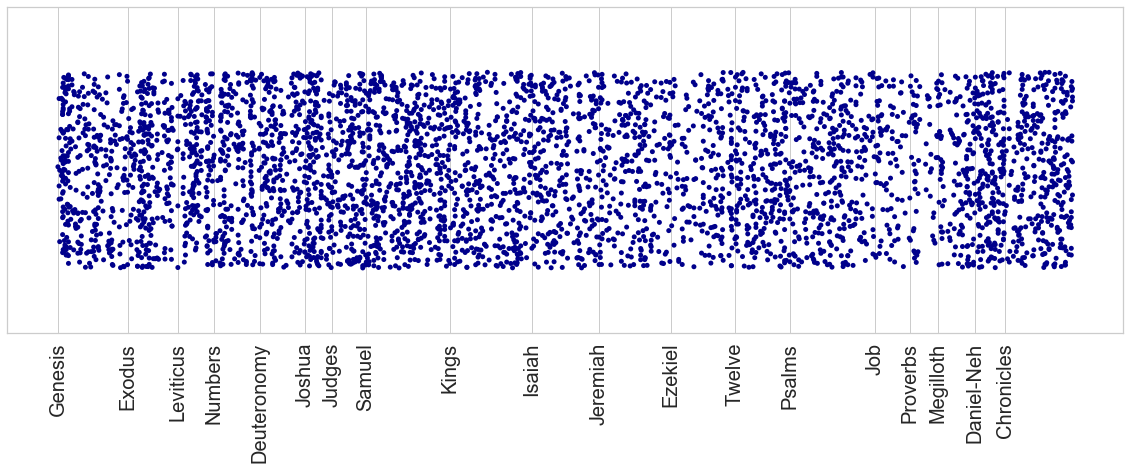

In [24]:
strip_title = 'Distribution of Time Function Constructions by segments of ~50 clauses (smaller books are grouped together)'
plt.figure(figsize=(20, 6))
sns.stripplot(x=strip_data, jitter=0.3, color='darkblue')
plt.xticks(ticks=list(bookboundaries.values()), labels=list(bookboundaries.keys()), rotation='vertical', size=20)
plt.savefig(fg_path('distribution_by_50clauses.png'), dpi=300, bbox_inches='tight')
print(strip_title) # keep title out of savefig
print('x-axis: Nth clause cluster')
print('y-axis: random jitter effect for visibility')
plt.show()

We can see a slightly sparser population of time adverbials in some of the poetic books, especially Job-Proverbs.

## Top Surface Forms

In [48]:
token_counts = pd.DataFrame(times.token.value_counts())

token_counts.head(25)

,token
עוד,344
עתה,340
ב.ה.יום.ה.הוא,201
ה.יום,191
אז,117
ל.עולם,99
ב.ה.בקר,78
כל.ה.יום,76
עד.ה.יום.ה.זה,71
אחר,67


## Noun / Adverb Distinction?

In the surface forms we can recognize numerous features which are common to phrases in Hebrew: prepositions, plural morphemes, definite articles, demonstratives. We also see modifications of number with cardinal number quantifiers or qualitative quantifiers like כל. **In the quest to specify the semantics and build semantic classes, we need to know how these various constructions relate to one another.** What does each element contribute to the whole? What is their relationship to one another? How does their use contribute to the precise meaning of a phrase? 

A cursory overview of the time adverbial surface forms above shows that not all time-words combine evenly with these features. Some regularly do, such as יום. But other words like עתה, אז, עולם seem to appear on their own more often, occasionally with a preposition. These are words that are often classified as "particles" or quintessential "adverbs".

### Variability Demonstrated: עולם

A closer inspection of certain so-called particles reveals that these larger tendencies are not always absolute, but variable. Take עולם, for example. Below we count and reveal all of its surface forms.

In [71]:
olam = times.query('time == "עולם"')
olam_tokens = pd.DataFrame(olam.token.value_counts())
display(olam_tokens)

,token
ל.עולם,99
עד.עולם,53
עולם,9
מן.עולם,7
מן.ה.עולם,2
עד.ל.עולם,2
עד.עולם.עד,1
עד.ה.עולם,1


Let's count up the relevant features in the phrases.

In [95]:
olam_features = pd.pivot_table(olam, index='time', values=['bare', 'definite', 'time_pl'], aggfunc=np.sum)
olam_features['total'] = olam_features.sum(1)
olam_features

,bare,definite,time_pl,total
time,,,,
עולם,170.0,3.0,5.0,178.0


Inspection of the various forms occuring with עולם as the head shows variable preference for nominalizing constructions. The vast majority (170/178) appear without modifications ("bare") like definite articles and pluralization. But 8 cases do deploy nominalizing constructions such as definites and plurals.

**How do we account for both the tendencies and the variability of words like these?** And how does that inform our analysis of the semantics?

I propose, in line with the approach of Construction Grammar, to avoid assuming a univeral word class (e.g. "noun" versus "adverb"). Rather, parts-of-speech tendencies are manifested through collocational patterns. Some words may be highly associated with a given pattern, and the associations may even be semantically motivated. For instance, the word אישׁ will co-occur requently with patterns associated with (animate) objects. The high co-occurrence frequency is motivated by the meaning of the word itself. Framed in this way, we can talk more about a continuum of uses: a word may be more or less associated with contexts that indicate, for example, an object (traditionally a "noun"). 

Croft also treats parts of speech as a continuum of semantic features rather than discrete categories (Croft, *Radical Construction Grammar*, 2001). He provides the following illustration for constructions in English which characterize that continuum (2001: 99):

<img height=30% width=30% src="../../docs/images/figures/Croft_2001_POS_map.jpg">

Croft notes two axes along with language encodes certain functions. The y-axis denotes an object-to-action continuum, whereas the x-axis denotes a reference-to-predication continuum. Words that are prototypical nouns will co-occur often with constructions indicating referentiality (REF) and object attributes (OBJECT). This is the upper left-hand corner. Croft lists indicators of "number" as such a marker. On the opposite corner are words which are heavily construed as actions with predication, i.e. prototypical verbs. These co-occur with morpheme markers like tense or modality. 

Can we model this continuum somehow? Doing so would enable us to look for subtle collocational tendencies above the level of the phrase. For example, in a previous study, I found prelimary evidence that the *yiqṭol* verb tends to collocate with time adverbials which do not nominalize with features such as definite articles (see results [here](https://github.com/CambridgeSemiticsLab/BH_time_collocations/blob/master/archive/2019-10-31/analysis/exploratory/construction_clusters.ipynb)). Or, to put it simply, it seems that *yiq̣tol* prefers times with more particle-like than nominal behavior. If we were to have more precise data about time-word behavior, we could more accurately measure these kinds of clause-level tendencies.

## Build Time Adverbial Components Dataset

In [21]:
single_tas = class2cx['single'] - class2cx['component']

print(f'Number of single time adverbials: {len(single_tas)}')

Number of single time adverbials: 3823


The remaining time adverbials are now further filtered based on the exclusions noted above. They will be stored based on the lexeme string of their heads.

In [2]:
# test = pd.pivot_table(
#     times, 
#     index=['time'], 
#     values=['time_pl', 'quantified', 'definite', 
#             'demonstrative', 'ordinal', 'time_sffx',
#             'bare'],
#     aggfunc=np.sum
# )

# test

# test.loc[test.sum(1).sort_values(ascending=False).index]

We now have a co-occurrence matrix that contains all of our counts. Let's have a look at the top values.

## Dataset Stats

### Raw sums across features

In [133]:
head_cols.sum()

total     3807.0
pl.        614.0
quant.     630.0
defi.     1280.0
demon.     486.0
geni.      409.0
ordn.      151.0
sffx.      136.0
ø         1500.0
dtype: float64

## Pruning
Some heads will occur only once or so. We will remove any cases with a sample size `< 5`.

In [134]:
head_cols_pruned = head_cols[head_cols['total'] > 4]

Here is the comparison of size after we've applied our pruning.

In [135]:
head_cols.shape # before

(104, 9)

In [136]:
head_cols_pruned.shape # after

(42, 9)

We also drop the `total` column from the table, as it is not needed in the pruned dataset. We store it in another DF to use it for calculating ratios.

In [137]:
head_totals = head_cols_pruned['total']
head_cols_pruned = head_cols_pruned.drop('total', 1)

### Normalization: ratio

There are a number of ways to normalize the counts so that more and less common words are evenly compared. We can use a contingency-based method, which looks at each count in relation to the size of the dataset. This would allow us to isolate relationships which are statistically significant to a particular word. We can also use a non-contingency method such as a simple ratio (percentage). In this case, the ratio makes a bit more sense because we want to focus more closely on each word's own distributional tendencies. None of the data can be "statistically insignificant". The data is normalized below. Each decimal value is out of 1.

In [138]:
head_cols_ratio = head_cols_pruned.divide(head_cols_pruned.sum(1), axis=0)

head_cols_ratio.head(10)

,pl.,quant.,defi.,demon.,geni.,ordn.,sffx.,ø
יום,0.160467,0.137976,0.349481,0.163495,0.120242,0.047145,0.017301,0.003893
עתה,0.000000,0.000000,0.000000,0.005666,0.000000,0.000000,0.000000,0.994334
עוד,0.000000,0.000000,0.000000,0.000000,0.002841,0.002841,0.005682,0.988636
שׁנה,0.220896,0.528358,0.101493,0.020896,0.044776,0.056716,0.005970,0.020896
עת,0.019139,0.052632,0.334928,0.301435,0.224880,0.000000,0.047847,0.019139
עולם,0.028571,0.000000,0.017143,0.000000,0.005714,0.000000,0.000000,0.948571
לילה,0.029762,0.119048,0.476190,0.113095,0.000000,0.000000,0.000000,0.261905
אז,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
בקר,0.025862,0.000000,0.844828,0.000000,0.000000,0.000000,0.000000,0.129310
אחר,0.330000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330000,0.340000


### Clustering: PCA

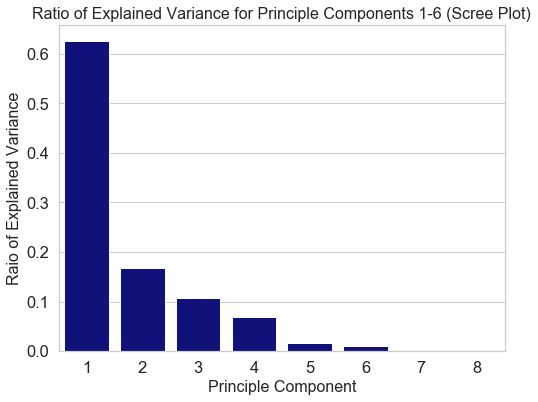

In [139]:
n_components = head_cols_ratio.shape[1]
pca = PCA(n_components)
pca_fit = pca.fit(head_cols_ratio.values)
pca_values = pca_fit.transform(head_cols_ratio)

plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(n_components)+1, y=pca_fit.explained_variance_ratio_[:n_components], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-6 (Scree Plot)', size=16)
plt.show()

In [140]:
loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_) # to CHECK!
loadings = pd.DataFrame(loadings.T, index=np.arange(n_components)+1, columns=head_cols_ratio.columns)

In [141]:
loadings[:3]

,pl.,quant.,defi.,demon.,geni.,ordn.,sffx.,ø
1,0.085027,0.079580,0.173878,0.021556,0.045418,0.007614,0.050656,-0.463729
2,-0.128889,-0.036906,0.207813,0.005540,0.004649,-0.002294,-0.088839,0.038926
3,-0.043361,0.186172,-0.021187,-0.004289,-0.059500,0.005539,-0.066255,0.002881


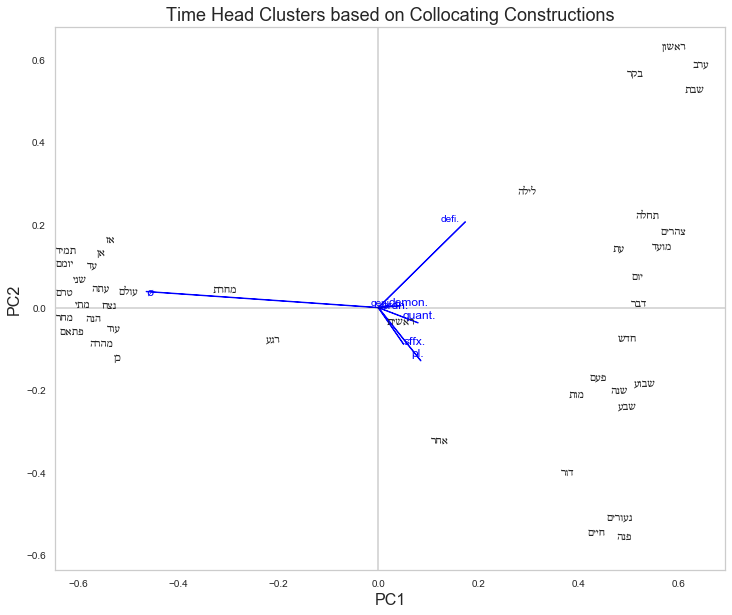

In [144]:
# -- plot words --
x, y = (pca_values[:,0], pca_values[:,1])
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='')
plt.grid(b=None)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('PC1', size=16)
plt.ylabel('PC2', size=16)
plt.axhline(color='black', linestyle='-', linewidth=0.3)
plt.axvline(color='black', linestyle='-', linewidth=0.3)

# -- annotate words --
texts = []
text_strings = head_cols_ratio.index
text_strings = [get_display(s).replace('\u05C1','') for s in text_strings]
for i, txt in enumerate(text_strings):
    tx, ty = x[i], y[i]
    texts.append(
        plt.text(
            tx, ty, txt, 
            size=11,
            weight='heavy',
            family='serif',
        )
    )
    
# -- annotate features --
# configure offsets / feature-specific font sizes:
# offsets = {
#     'quant.': (-0.03, 0.01, 12),
#     'prep.': (-0.04, -0.02, 12),
#     'pl.': (-0.02, 0.01, 12),
#     'geni.': (-0.06, 0, 10),
#     'defi.': (-0.05, 0, 10),
#     'ø': (0, -0.01, 12),
# }
# skip_feat = ['sffx.', 'demon.', 'ordn.']
skip_feat = []
for feature in loadings:
    if feature in skip_feat:
        continue
    x_off, y_off, size = offsets.get(feature, (0,0,12)) # config offsets / size
    fx, fy = loadings[feature][:2]
    plt.arrow(0, 0, fx, fy, color='blue', linewidth=1, head_width=0)
    plt.text(fx+x_off, fy+y_off, feature, color='blue', size=size) 

adjust_text(texts) # clean up overlapping annotations

plt.savefig(fg_path('time_head_clusters.png'), dpi=300, bbox_inches='tight') # save plot
plt.title('Time Head Clusters based on Collocating Constructions', size=18) 
plt.show()

## Analysis of PCA Results

Two primary groups with a potential third sub-group. The blue arrows show us the features which are influencing the locations on the graph. The two strongest influences are prepositions and zero-marking. These separate words along the x-axis. From the perspective of the x-axis alone, we see mainly two groups, based on colloca 

Note that the presence of constructions indicating definiteness (ה), quantifiers, demonstratives, and plurality pull the largest cluster to the first and second quadrants (`y>0`).  

In [143]:
head_components = pd.DataFrame(
    pca_values, 
    columns=[f'PC{i+1}' for i in np.arange(head_cols_pruned.shape[1])], 
    index=head_cols_pruned.index
)

head_components[:10]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
יום,0.505477,0.058020,0.004720,0.013475,0.138992,0.050233,0.027887,7.371595e-17
עתה,-0.574291,0.027590,0.005875,-0.022775,0.000889,0.007126,0.001086,-1.395300e-17
עוד,-0.568533,0.024764,0.003415,-0.020164,-0.005726,0.005192,0.004473,-4.987517e-17
שׁנה,0.463043,-0.217518,0.387916,0.037329,0.044303,-0.049640,0.023773,9.704799e-17
עת,0.467535,0.124170,-0.082563,0.153607,0.182082,0.207385,-0.006897,1.547965e-16
עולם,-0.522191,0.020418,-0.003789,-0.031179,0.006481,-0.010198,-0.001732,-1.735201e-17
לילה,0.275780,0.263951,0.044602,-0.089833,0.036812,0.069914,-0.008566,9.053446e-18
אז,-0.579642,0.028302,0.006067,-0.023257,-0.003029,0.002716,0.001066,-3.262688e-17
בקר,0.496376,0.548859,-0.095450,-0.192166,-0.061519,-0.034304,-0.007953,-1.881711e-17
אחר,0.103182,-0.338732,-0.173465,-0.128343,-0.089631,0.043455,0.002468,-4.786117e-17


### Standalone Adverbs?

In [67]:
indep_advb = head_components[head_components['PC1'] > 0.4].iloc[:, :2]

indep_advb

,PC1,PC2
עוד,0.806516,-0.129566
עתה,0.815125,-0.131312
אז,0.766014,-0.144200
תמיד,0.843266,-0.129435
מחר,0.694132,-0.157940
יומם,0.785787,-0.140421
פתאם,0.843266,-0.129435
שׁני,0.843266,-0.129435
מהרה,0.843266,-0.129435
טרם,0.843266,-0.129435


#### Have a look at their tense tendencies

In [71]:
iadvb_tenses = tense_cols.loc[indep_advb.index]

iadvb_tenses

,wyqṭl,qṭl,ptcp,yqṭl,wqṭl
עוד,48.0,42.0,24.0,198.0,8.0
עתה,0.0,45.0,2.0,44.0,0.0
אז,1.0,43.0,3.0,72.0,0.0
תמיד,0.0,2.0,6.0,18.0,6.0
מחר,0.0,1.0,4.0,20.0,1.0
יומם,1.0,5.0,1.0,8.0,1.0
פתאם,4.0,5.0,1.0,12.0,1.0
שׁני,12.0,0.0,0.0,2.0,3.0
מהרה,2.0,2.0,0.0,3.0,2.0
טרם,0.0,2.0,0.0,9.0,0.0


In [75]:
iadvb_tenses.div(iadvb_tenses.sum(1), axis=0)

,wyqṭl,qṭl,ptcp,yqṭl,wqṭl
עוד,0.150000,0.131250,0.075000,0.618750,0.025000
עתה,0.000000,0.494505,0.021978,0.483516,0.000000
אז,0.008403,0.361345,0.025210,0.605042,0.000000
תמיד,0.000000,0.062500,0.187500,0.562500,0.187500
מחר,0.000000,0.038462,0.153846,0.769231,0.038462
יומם,0.062500,0.312500,0.062500,0.500000,0.062500
פתאם,0.173913,0.217391,0.043478,0.521739,0.043478
שׁני,0.705882,0.000000,0.000000,0.117647,0.176471
מהרה,0.222222,0.222222,0.000000,0.333333,0.222222
טרם,0.000000,0.181818,0.000000,0.818182,0.000000


In [85]:
iadvb_tenses.shape

(10, 5)

### Prepositional Adverbs?

In [78]:
dep_advb = head_components[
    (head_components['PC1'] < 0) & (head_components['PC2'] < -0.2)
].iloc[:, :2]

dep_advb

,PC1,PC2
עולם,-0.465291,-0.340966
כן,-0.536222,-0.393104
מחרת,-0.439531,-0.257697
נצח,-0.415282,-0.349038
מתי,-0.536222,-0.393104
עד,-0.536222,-0.393104
אן,-0.536222,-0.393104
הנה,-0.536222,-0.393104


In [80]:
dadvb_tenses = tense_cols.loc[dep_advb.index]

dadvb_tenses

,wyqṭl,qṭl,ptcp,yqṭl,wqṭl
עולם,6.0,23.0,9.0,77.0,19.0
כן,21.0,11.0,0.0,18.0,0.0
מחרת,21.0,0.0,0.0,2.0,0.0
נצח,0.0,4.0,1.0,20.0,0.0
מתי,0.0,2.0,2.0,16.0,0.0
עד,0.0,0.0,3.0,11.0,0.0
אן,0.0,2.0,1.0,11.0,0.0
הנה,0.0,2.0,1.0,1.0,0.0


In [83]:
dadvb_tenses.div(dadvb_tenses.sum(1), axis=0)

,wyqṭl,qṭl,ptcp,yqṭl,wqṭl
עולם,0.044776,0.171642,0.067164,0.574627,0.141791
כן,0.420000,0.220000,0.000000,0.360000,0.000000
מחרת,0.913043,0.000000,0.000000,0.086957,0.000000
נצח,0.000000,0.160000,0.040000,0.800000,0.000000
מתי,0.000000,0.100000,0.100000,0.800000,0.000000
עד,0.000000,0.000000,0.214286,0.785714,0.000000
אן,0.000000,0.142857,0.071429,0.785714,0.000000
הנה,0.000000,0.500000,0.250000,0.250000,0.000000


In [84]:
dadvb_tenses.shape

(8, 5)

### Independent and dependent adverbs together versus everything else

In [90]:
both_adverb = iadvb_tenses.append(dadvb_tenses)

both_adverb

,wyqṭl,qṭl,ptcp,yqṭl,wqṭl
עוד,48.0,42.0,24.0,198.0,8.0
עתה,0.0,45.0,2.0,44.0,0.0
אז,1.0,43.0,3.0,72.0,0.0
תמיד,0.0,2.0,6.0,18.0,6.0
מחר,0.0,1.0,4.0,20.0,1.0
יומם,1.0,5.0,1.0,8.0,1.0
פתאם,4.0,5.0,1.0,12.0,1.0
שׁני,12.0,0.0,0.0,2.0,3.0
מהרה,2.0,2.0,0.0,3.0,2.0
טרם,0.0,2.0,0.0,9.0,0.0


In [92]:
both_adverb.sum() / both_adverb.sum().sum()

wyqṭl    0.122363
qṭl      0.201477
ptcp      0.061181
yqṭl     0.571730
wqṭl     0.043249
dtype: float64

Here ^ we see that nearly 60% of these adverb uses are collocations with yiqṭol. How does that compare with the rest?

In [108]:
all_others = tense_cols.loc[~tense_cols.index.isin(both_adverb.index)]

all_others.head()

,wyqṭl,qṭl,ptcp,yqṭl,wqṭl
עת,31.0,29.0,12.0,42.0,6.0
יום,257.0,331.0,89.0,329.0,96.0
שׁנה,67.0,99.0,3.0,36.0,11.0
צהרים,3.0,1.0,0.0,6.0,2.0
חדשׁ,14.0,16.0,3.0,6.0,2.0


In [111]:
all_others.sum() / all_others.sum().sum()

wyqṭl    0.262854
qṭl      0.302739
ptcp      0.073522
yqṭl     0.283518
wqṭl     0.077367
dtype: float64

In [128]:
yiqtol_sums = {
    'iadvb': iadvb_tenses.sum(),
    'dadvb': dadvb_tenses.sum(),
    'other': all_others.sum(),
}

yiqtol_sums = pd.DataFrame.from_dict(yiqtol_sums, orient='index')

yiqtol_sums

,wyqṭl,qṭl,ptcp,yqṭl,wqṭl
iadvb,68.0,147.0,41.0,386.0,22.0
dadvb,48.0,44.0,17.0,156.0,19.0
other,547.0,630.0,153.0,590.0,161.0


We can now apply a measure of association between the three groups. We can see that both dependent and independent adverbs are associated with yiqtol.

In [129]:
apply_fishers(yiqtol_sums)

,wyqṭl,qṭl,ptcp,yqṭl,wqṭl
iadvb,-17.475281,-2.958936,-0.409611,34.195486,-4.355975
dadvb,-1.460780,-5.797529,-0.205074,9.538708,-0.000000
other,18.571457,8.379914,0.605241,-50.469357,3.412828
